# Red Light Violation vs Accident Probability Analysis

This notebook studies the incidence of injection rate (α) on accident probability for different red light violation probabilities (p_red).

## Import Libraries and Setup

In [5]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add parent directory to path to import project modules
sys.path.insert(0, os.path.abspath('..'))

from dispatcher import SimulationDispatcher, generate_parameter_grid

# Set seaborn theme for consistent styling
sns.set_theme(style="whitegrid", palette="Set2")
plt.rcParams['figure.dpi'] = 100

## Simulation Parameters

We fix the following parameters:
- Road length: 200
- Maximum velocity (vmax): 4
- Random braking probability (p_b): 0.1
- Lane change probability (p_chg): 0.1
- Skid probability (p_skid): 0
- Green light period (t_green): 40

We vary:
- Injection rate (α): 20 values from 0.05 to 1.0
- Red light violation probability (p_red): {0, 0.05, 0.1, 0.2, 0.5}

In [6]:
# Fixed parameters
LENGTH = 100
VMAX = 4
P_B = 0.1
P_CHG = 0.1
P_SKID = 0.0
T_GREEN = 40
STEPS = 100000
REPLICATIONS = 5

# Variable parameters
injection_rates = np.linspace(0.05, 1.0, 20)
p_red_values = [0.0, 0.05, 0.1, 0.2, 0.5, 0.8]

print(f"Number of injection rate values: {len(injection_rates)}")
print(f"Injection rates: {injection_rates}")
print(f"p_red values: {p_red_values}")
print(f"Number of replications per configuration: {REPLICATIONS}")
print(f"Total simulations: {len(injection_rates) * len(p_red_values) * REPLICATIONS}")

Number of injection rate values: 20
Injection rates: [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]
p_red values: [0.0, 0.05, 0.1, 0.2, 0.5, 0.8]
Number of replications per configuration: 5
Total simulations: 600


## Generate Simulation Configurations

In [7]:
# Generate all parameter combinations
configs = generate_parameter_grid(
    length_values=[LENGTH],
    vmax_values=[VMAX],
    t_green_values=[T_GREEN],
    injection_rate_values=injection_rates.tolist(),
    p_b_values=[P_B],
    p_chg_values=[P_CHG],
    p_red_values=p_red_values,
    p_skid_values=[P_SKID],
    steps=STEPS,
    metrics_start_step=0,
    replications=REPLICATIONS
)

print(f"Generated {len(configs)} simulation configurations")
print(f"\nFirst configuration:")
print(configs[0])

output_file = "p_red_test.csv"

Generated 600 simulation configurations

First configuration:
SimulationConfig(length=100, vmax=4, t_green=40, injection_rate=0.05, p_b=0.1, p_chg=0.1, p_red=0.0, p_skid=0.0, steps=100000, metrics_start_step=0, config_id=0)


## Run Simulations

This will take some time. The dispatcher will run all simulations in parallel and save results to a CSV file.

In [ ]:
# Create dispatcher and run simulation

dispatcher = SimulationDispatcher(
    output_file=output_file,
    use_multiprocessing=True,
    max_workers=None,  # Use all available CPU cores
    verbose=True
)

# Run all simulations
results = dispatcher.run(configs)

print(f"\nSimulations complete! Results saved to {output_file}")

## Load and Process Results

In [8]:
# Load results from CSV
df = pd.read_csv(output_file)

# Display basic info
print(f"Total rows: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Total rows: 600

Columns: ['timestamp', 'config_id', 'length', 'vmax', 't_green', 'injection_rate', 'p_b', 'p_chg', 'p_red', 'p_skid', 'steps', 'metrics_start_step', 'n_lateral', 'n_rear_end', 'n_vehicles', 'throughput', 'lateral_to_rear_end_ratio', 'time', 'total_time', 'completed_vehicles', 'avg_travel_time', 'avg_speed']

First few rows:


,timestamp,config_id,length,vmax,t_green,injection_rate,p_b,p_chg,p_red,p_skid,...,n_lateral,n_rear_end,n_vehicles,throughput,lateral_to_rear_end_ratio,time,total_time,completed_vehicles,avg_travel_time,avg_speed
0,2025-11-06T10:59:53.908053,18,100,4,40,0.05,0.1,0.1,0.2,0.0,...,40,0,4723,4723,0,1.482233,1.482386,4641,29.710838,3.433091
1,2025-11-06T10:59:53.951552,15,100,4,40,0.05,0.1,0.1,0.2,0.0,...,42,0,4971,4971,0,1.526161,1.526316,4887,29.546347,3.452203
2,2025-11-06T10:59:53.957895,16,100,4,40,0.05,0.1,0.1,0.2,0.0,...,49,0,4991,4988,0,1.532348,1.532500,4887,29.697156,3.434672
3,2025-11-06T10:59:53.977130,19,100,4,40,0.05,0.1,0.1,0.2,0.0,...,56,0,5031,5030,0,1.537766,1.537905,4914,29.593203,3.446737
4,2025-11-06T10:59:53.985406,17,100,4,40,0.05,0.1,0.1,0.2,0.0,...,51,0,5031,5030,0,1.559803,1.559953,4927,29.588593,3.447274


## Calculate Accident Probability

The accident probability (P_acc) is calculated as:

$$P_{acc} = \frac{\text{Number of accidents}}{\text{Time steps} \times \text{Throughput}}$$

Where:
- Number of accidents = n_lateral + n_rear_end (total accidents)
- Time steps = simulation steps
- Throughput = number of cars that passed through the intersection

In [9]:
# Calculate total accidents and accident probability
df['total_accidents'] = df['n_lateral'] + df['n_rear_end']

# P_acc = Number of accidents / (Time steps * Throughput)
# Avoid division by zero
df['p_acc'] = df.apply(
    lambda row: row['total_accidents'] / (row['steps'] * row['throughput']) 
    if row['throughput'] > 0 else 0, 
    axis=1
)

# Display sample calculations
print("Sample calculations:")
print(df[['injection_rate', 'p_red', 'total_accidents', 'steps', 'throughput', 'p_acc']].head(10))

Sample calculations:
   injection_rate  p_red  total_accidents   steps  throughput         p_acc
0            0.05   0.20               40  100000        4723  8.469193e-08
1            0.05   0.20               42  100000        4971  8.449004e-08
2            0.05   0.20               49  100000        4988  9.823577e-08
3            0.05   0.20               56  100000        5030  1.113320e-07
4            0.05   0.20               51  100000        5030  1.013917e-07
5            0.05   0.10               60  100000        4933  1.216298e-07
6            0.05   0.10               46  100000        4925  9.340102e-08
7            0.05   0.10               40  100000        4979  8.033742e-08
8            0.05   0.10               50  100000        5064  9.873618e-08
9            0.05   0.05               33  100000        4853  6.799918e-08


## Aggregate Results

Average the accident probability across all replications for each combination of injection_rate and p_red.

In [10]:
# Group by injection_rate and p_red, then calculate mean and std
aggregated = df.groupby(['injection_rate', 'p_red']).agg({
    'p_acc': ['mean', 'std', 'count'],
    'throughput': 'mean',
    'total_accidents': 'mean'
}).reset_index()

# Flatten column names
aggregated.columns = ['injection_rate', 'p_red', 'p_acc_mean', 'p_acc_std', 'n_replications', 'throughput_mean', 'accidents_mean']

print(f"Aggregated data shape: {aggregated.shape}")
print(f"\nSample aggregated data:")
aggregated.head(10)

Aggregated data shape: (120, 7)

Sample aggregated data:


,injection_rate,p_red,p_acc_mean,p_acc_std,n_replications,throughput_mean,accidents_mean
0,0.05,0.00,0.000000e+00,0.000000e+00,5,4983.6,0.0
1,0.05,0.05,6.628375e-08,9.218964e-09,5,4979.6,33.0
2,0.05,0.10,9.649567e-08,1.559948e-08,5,4998.6,48.2
3,0.05,0.20,9.602828e-08,1.150529e-08,5,4948.4,47.6
4,0.05,0.50,8.519825e-08,1.676049e-08,5,4949.4,42.2
5,0.05,0.80,6.233989e-08,7.416325e-09,5,4942.2,30.8
6,0.10,0.00,0.000000e+00,0.000000e+00,5,9981.6,0.0
7,0.10,0.05,1.223624e-07,1.154882e-08,5,9874.0,120.8
8,0.10,0.10,1.606005e-07,1.361114e-08,5,9926.6,159.4
9,0.10,0.20,1.907829e-07,1.210512e-08,5,9972.8,190.2


## Create Plot: P_acc vs α for Different p_red Values

This plot shows how accident probability varies with injection rate for different red light violation probabilities.

Plot saved as 'p_red_plot.png'


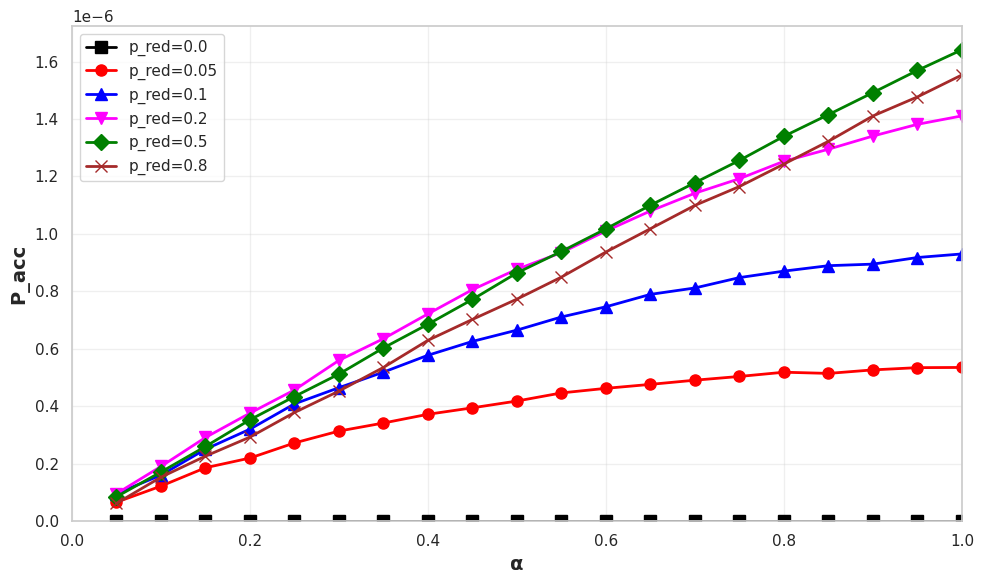

In [15]:
# Create the plot
plt.figure(figsize=(10, 6))

# Define markers and colors for each p_red value
markers = ['s', 'o', '^', 'v', 'D', 'x']
colors = ['black', 'red', 'blue', 'magenta', 'green', "brown"]

# Plot each p_red value as a separate line
for i, p_red in enumerate(p_red_values):
    data = aggregated[aggregated['p_red'] == p_red]
    
    plt.plot(
        data['injection_rate'], 
        data['p_acc_mean'],
        marker=markers[i],
        color=colors[i],
        linestyle='-',
        linewidth=2,
        markersize=8,
        label=f'p_red={p_red}',
        markerfacecolor=colors[i],
        markeredgecolor=colors[i]
    )

# Formatting
plt.xlabel('α', fontsize=14, fontweight='bold')
plt.ylabel('P_acc', fontsize=14, fontweight='bold')
plt.xlim(0, 1.0)
plt.ylim(bottom=0)
plt.legend(loc='best', frameon=True, fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
plt.savefig('p_red_plot.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'p_red_plot.png'")

plt.show()

## Summary Statistics

Display some key statistics about the results.

In [16]:
# Find peak accident probability for each p_red
print("Peak accident probability (P_acc) for each p_red value:\n")
for p_red in p_red_values:
    data = aggregated[aggregated['p_red'] == p_red]
    max_idx = data['p_acc_mean'].idxmax()
    max_row = data.loc[max_idx]
    
    print(f"p_red = {p_red}:")
    print(f"  Maximum P_acc = {max_row['p_acc_mean']:.6f} at α = {max_row['injection_rate']:.3f}")
    print(f"  Throughput = {max_row['throughput_mean']:.1f}")
    print(f"  Accidents = {max_row['accidents_mean']:.2f}")
    print()

# Overall statistics
print("\nOverall statistics:")
print(f"Total simulations run: {len(df)}")
print(f"Total unique configurations: {len(aggregated)}")
print(f"Replications per configuration: {REPLICATIONS}")
print(f"Injection rate range: [{injection_rates.min():.2f}, {injection_rates.max():.2f}]")
print(f"p_red values tested: {p_red_values}")

Peak accident probability (P_acc) for each p_red value:

p_red = 0.0:
  Maximum P_acc = 0.000000 at α = 0.050
  Throughput = 4983.6
  Accidents = 0.00

p_red = 0.05:
  Maximum P_acc = 0.000001 at α = 1.000
  Throughput = 92100.6
  Accidents = 4930.20

p_red = 0.1:
  Maximum P_acc = 0.000001 at α = 1.000
  Throughput = 92135.2
  Accidents = 8572.40

p_red = 0.2:
  Maximum P_acc = 0.000001 at α = 1.000
  Throughput = 92145.6
  Accidents = 13001.20

p_red = 0.5:
  Maximum P_acc = 0.000002 at α = 1.000
  Throughput = 92085.8
  Accidents = 15112.60

p_red = 0.8:
  Maximum P_acc = 0.000002 at α = 1.000
  Throughput = 92076.0
  Accidents = 14303.60


Overall statistics:
Total simulations run: 600
Total unique configurations: 120
Replications per configuration: 5
Injection rate range: [0.05, 1.00]
p_red values tested: [0.0, 0.05, 0.1, 0.2, 0.5, 0.8]


## Interpretation

The plot shows how the accident probability (P_acc) varies with the injection rate (α) for different red light violation probabilities (p_red):

1. **Curve Shape**: For most p_red values, P_acc follows a characteristic pattern:
   - Increases with α at low injection rates
   - Reaches a maximum at intermediate injection rates
   - Decreases at very high injection rates (saturation regime)

2. **Effect of p_red**: Higher red light violation probabilities generally lead to higher accident probabilities, as more vehicles running red lights create dangerous intersection conflicts and increase the risk of collisions.

3. **Saturation Effect**: At very high injection rates (α → 1), the road becomes saturated with vehicles, which actually reduces the accident probability per vehicle because vehicles are forced to move more slowly.

4. **Critical Injection Rate**: Each p_red value has a critical injection rate where accidents are most likely, representing the transition between free-flow and congested traffic regimes.

5. **Traffic Light Safety**: The analysis reveals the importance of red light compliance in intersection safety. Even small increases in p_red can significantly increase accident risk, especially at moderate traffic densities where vehicles have enough speed to cause serious collisions but the flow is not yet saturated.

Why is accident risk lower for p_red=0.8 than for p_red=0.5?
This counter-intuitive result likely occurs due to implicit traffic synchronization at very high red light violation probabilities:

When p_red=0.8: Nearly all vehicles (80%) ignore the traffic light, effectively creating a scenario similar to having no traffic light at all. Drivers may develop a more cautious, uniform behavior where everyone assumes others will run the red light.

When p_red=0.5: This creates the most dangerous scenario - maximum uncertainty. Some vehicles stop, others don't. This unpredictability leads to:

Mixed behaviors at the intersection: Vehicles that respect the light suddenly encounter vehicles that don't
Speed differentials: Stopped or slowing vehicles vs. full-speed violators
Difficult decision-making: Drivers don't know what others will do
Paradoxical safety at extremes:

At p_red=0.0, everyone stops → predictable, safe
At p_red=0.8, almost everyone runs → predictable (in its own way), relatively safer than p_red=0.5
At p_red=0.5, complete chaos → maximum accidents
This is analogous to traffic studies showing that intersections with broken traffic lights (where everyone treats it as a 4-way stop) can sometimes be safer than partially functioning lights.

Why logarithmic growth for p_red ≤ 0.2 but linear for p_red ≥ 0.5?
For p_red ≤ 0.2 (Logarithmic/Saturating Growth):
Traffic light still dominant: The majority still respect the light, so it effectively controls traffic flow
Saturation effect: As injection rate increases, the throughput saturates due to traffic light constraints. Fewer vehicles can physically pass through, limiting collision opportunities
Congestion dampening: Higher density → slower speeds → lower energy collisions → curve flattens
For p_red ≥ 0.5 (Linear Growth):
Traffic light loses control: With >50% violations, the light no longer effectively regulates flow
Free-flow regime: The intersection behaves more like an unregulated crossing where throughput scales more directly with injection rate
Constant hazard rate: Each additional vehicle has roughly the same probability of causing an accident because:
The light doesn't prevent entry
No saturation effect from queuing
Vehicles maintain higher speeds even at higher densities
Why p_red=0.2 has higher risk at lower injection rates:
At low injection rates (α < 0.3):

For p_red=0.05: Very few violations, light effectively manages sparse traffic
For p_red=0.2: Enough violations to create dangerous conflicts, but not enough traffic density to force cautious behavior
Critical violation threshold: 20% violations is enough to create frequent dangerous situations without the self-regulating effect of congestion
This suggests there's an optimal violation rate for safety that paradoxically isn't zero - it's either very low (<5%) where the light works, or very high (>80%) where everyone adapts to lawlessness. The middle ground (20-50%) represents the "valley of death" where unpredictability peaks.

Key Insight: This demonstrates a complex system property where intermediate levels of rule-breaking can be more dangerous than extreme levels, because extreme scenarios force behavioral adaptation while intermediate scenarios create maximum uncertainty.